In [1]:
from google.colab import drive                  
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

In [3]:
IMAGE_SIZE = [150, 150] 

epochs = 10
batch_size = 100

train_path = '/content/drive/MyDrive/JV/train'
test_path = '/content/drive/MyDrive/JV/test'

image_files_train = glob(train_path + '/*/*.jp*g')
image_files_test = glob(test_path + '/*/*.jp*g')


folders = glob(train_path + '/*')

print(len(image_files_train))
print(len(image_files_test))

468
198


In [4]:
vgg=VGG19(include_top=False,weights='imagenet',input_shape=(150,150,3))
for layer in vgg.layers:
    layer.trainable =False
x=Flatten()(vgg.output)
prediction=Dense(len(folders),activation='softmax')(x)
model=Model(inputs=vgg.input,outputs=prediction)
model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [5]:
import keras
model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy',metrics='accuracy')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [6]:
gen=ImageDataGenerator(rotation_range=20,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.1,zoom_range=0.2,horizontal_flip=True,vertical_flip=True,preprocessing_function=preprocess_input)

In [7]:
test_gen=gen.flow_from_directory(test_path,target_size=IMAGE_SIZE)

Found 1797 images belonging to 5 classes.


In [8]:
labels = [None] * len(test_gen.class_indices)
print(labels)
for k, v in test_gen.class_indices.items():
  labels[v] = k
print(labels[0])

[None, None, None, None, None]
Daisy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -99.60692 max: 144.35165
[0. 0. 0. 0. 1.]


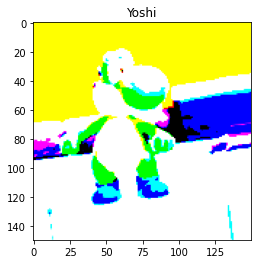

In [9]:
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  print(y[0])
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [10]:
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  test_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 4187 images belonging to 5 classes.
Found 1797 images belonging to 5 classes.


In [11]:
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files_train) // batch_size,
  validation_steps=len(image_files_test) // batch_size,
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
4/4 [==============================] - 282s 61s/step - loss: 16.0649 - accuracy: 0.2147 - val_loss: 8.1290 - val_accuracy: 0.4000
Epoch 2/10
1/4 [======>.......................] - ETA: 1:47 - loss: 8.2839 - accuracy: 0.3900

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


4/4 [==============================] - 227s 64s/step - loss: 7.3692 - accuracy: 0.4743 - val_loss: 6.5360 - val_accuracy: 0.6000
Epoch 3/10
4/4 [==============================] - 203s 57s/step - loss: 5.9248 - accuracy: 0.6113 - val_loss: 3.0051 - val_accuracy: 0.7600
Epoch 4/10
4/4 [==============================] - 183s 50s/step - loss: 4.1961 - accuracy: 0.6830 - val_loss: 2.9365 - val_accuracy: 0.8000
Epoch 5/10
4/4 [==============================] - 157s 44s/step - loss: 3.1310 - accuracy: 0.7740 - val_loss: 3.7078 - val_accuracy: 0.7700
Epoch 6/10
4/4 [==============================] - 137s 37s/step - loss: 4.6610 - accuracy: 0.7223 - val_loss: 3.4870 - val_accuracy: 0.8000
Epoch 7/10
4/4 [==============================] - 124s 35s/step - loss: 3.3540 - accuracy: 0.7926 - val_loss: 3.5588 - val_accuracy: 0.7400
Epoch 8/10
4/4 [==============================] - 119s 33s/step - loss: 3.4340 - accuracy: 0.7720 - val_loss: 3.0699 - val_accuracy: 0.8300
Epoch 9/10
4/4 [===============

In [12]:
STEP_SIZE_TEST=valid_generator.n//valid_generator.batch_size
valid_generator.reset()
pred=model.predict_generator(valid_generator,
steps=STEP_SIZE_TEST,
verbose=1)
predicted_class_indices_test=np.argmax(pred,axis=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


17/17 [==============================] - 238s 15s/step


In [13]:
STEP_SIZE_Train=train_generator.n//train_generator.batch_size
train_generator.reset()
pred2=model.predict_generator(train_generator,
steps=STEP_SIZE_Train,
verbose=1)
predicted_class_indices_train=np.argmax(pred2,axis=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 1/41 [..............................] - ETA: 1:43

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


41/41 [==============================] - 538s 13s/step


In [14]:
def get_confusion_matrix(data_path, N):
  
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [15]:
print(train_generator.class_indices) # pour le train
print(valid_generator.class_indices) # pour le test

{'Daisy': 0, 'Harmonie': 1, 'Tiny Kong': 2, 'Waluigi': 3, 'Yoshi': 4}
{'Daisy': 0, 'Harmonie': 1, 'Tiny Kong': 2, 'Waluigi': 3, 'Yoshi': 4}


Generating confusion matrix 468
Found 4187 images belonging to 5 classes.
Matrice de confusion pour le train


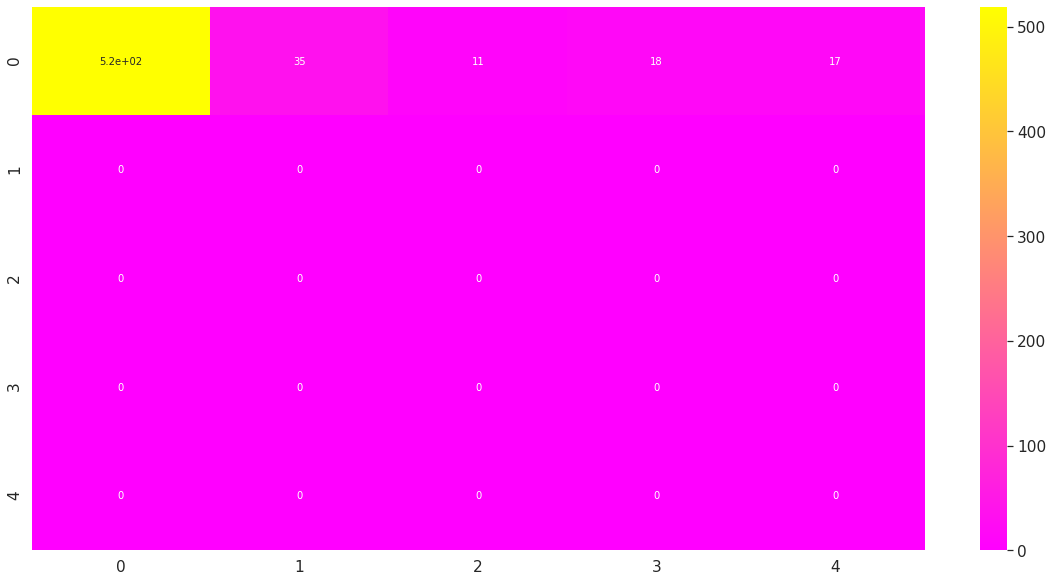

In [16]:
import seaborn as sns
import numpy as np
train_cm = get_confusion_matrix(train_path, len(image_files_train))
#print(train_cm)
print('Matrice de confusion pour le train')
plt.figure(figsize = (20,10))
sns.set(font_scale=1.4)
sns.heatmap(train_cm, annot=True, annot_kws={"size": 10}, cmap='spring')

Generating confusion matrix 198
Found 1797 images belonging to 5 classes.
Matrice de confusion pour le test


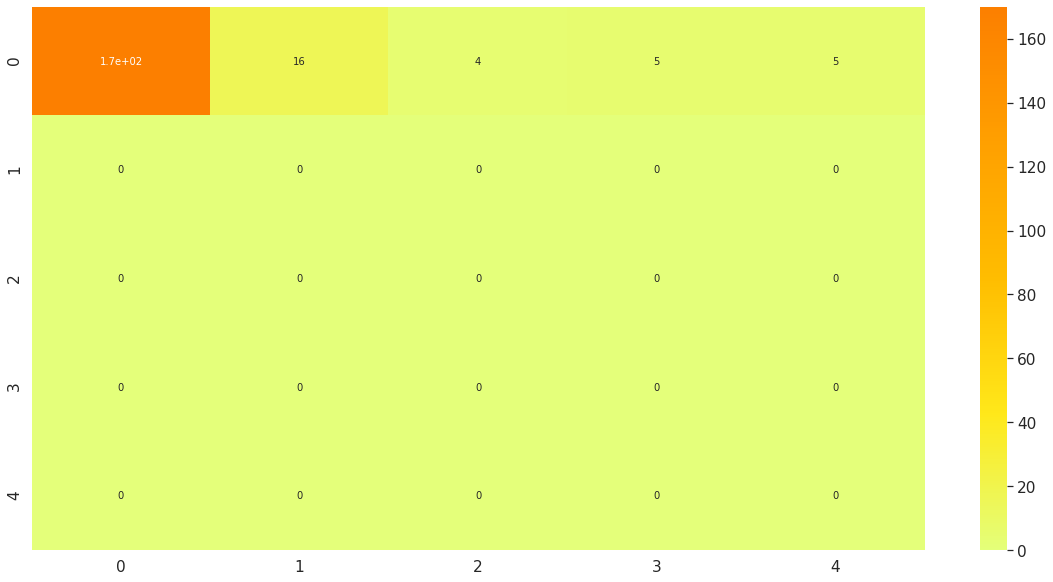

In [17]:
test_cm = get_confusion_matrix(test_path, len(image_files_test))
#print(test_cm)
print('Matrice de confusion pour le test')
plt.figure(figsize = (20,10))
sns.set(font_scale=1.4)
sns.heatmap(test_cm, annot=True, annot_kws={"size": 10}, cmap='Wistia')

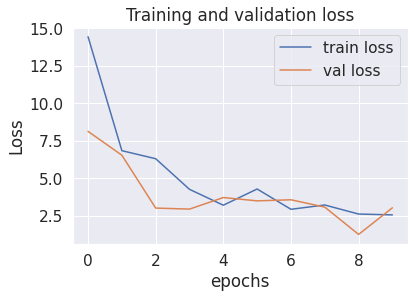

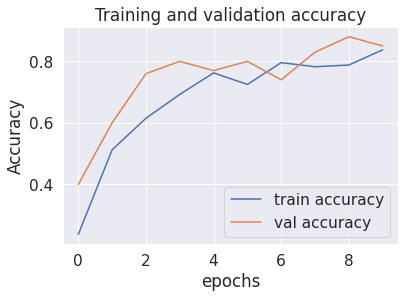

In [18]:
#print(r.history)
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
score_train = model.evaluate_generator(train_generator, len(image_files_train) // batch_size)
print(f'Train results - Loss: {score_train[0]} - Accuracy: {score_train[1]}')
score_test = model.evaluate_generator(valid_generator, len(image_files_test) // batch_size)
print(f'Test results - Loss: {score_test[0]} - Accuracy: {score_test[1]}')

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train results - Loss: 2.4733898639678955 - Accuracy: 0.8050000071525574
Test results - Loss: 2.1550371646881104 - Accuracy: 0.8700000047683716
